# Exploratory Data Analysis

The first step in any data science project is to getting know the data we work with.

In this notebook you can see a basic explanatory data analysis on New York Taxi dataset.

We will perform a basic statistical analysis that will help us to understand the behaviors of each feature and also examine and find outliers.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import math
import IPython
sns.set()

First we will load the data and immediately after that, as you can see, we will take a look of small portion of the data just to try and understand what it is about. After that we will start and examine it is main properties:
1. The size of the data.
2. The different types of features.

In [ ]:
import pandas as pd
from src.date_adjust import adjust_data_timespan

# Fetch the transactions dataset from the server
transactions_data = pd.read_csv('https://s3.wasabisys.com/iguazio/data/fraud-demo-mlrun-fs-docs/data.csv', parse_dates=['timestamp'])

# use only first 10k
transactions_data = transactions_data.sort_values(by='source', axis=0)[:10000]

# Adjust the samples timestamp for the past 2 days
transactions_data = adjust_data_timespan(transactions_data, new_period='2d')

# Sorting after adjusting timestamps
transactions_data = transactions_data.sort_values(by='timestamp', axis=0)
transactions_data['age'] = transactions_data['age'].astype(np.int)

# Preview
transactions_data.head(3)

<ipython-input-2-c3e732f551cf>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  transactions_data['age'] = transactions_data['age'].astype(np.int)


,step,age,gender,zipcodeOri,zipMerchant,category,amount,fraud,timestamp,source,target,device
274633,91,5,F,28007,28007,es_transportation,26.92,0,2023-06-17 14:34:57.213780000,C1022153336,M1823072687,33832bb8607545df97632a7ab02d69c4
286902,94,2,M,28007,28007,es_transportation,48.22,0,2023-06-17 14:35:15.507405913,C1006176917,M348934600,fadd829c49e74ffa86c8da3be75ada53
416998,131,3,M,28007,28007,es_transportation,17.56,0,2023-06-17 14:35:20.614575939,C1010936270,M348934600,58d0422a50bc40c89d2b4977b2f1beea


In [ ]:
# Fetch the user_events dataset from the server
user_events_data = pd.read_csv('https://s3.wasabisys.com/iguazio/data/fraud-demo-mlrun-fs-docs/events.csv', 
                               index_col=0, quotechar="\'", parse_dates=['timestamp'])

# Adjust to the last 2 days to see the latest aggregations in the online feature vectors
user_events_data = adjust_data_timespan(user_events_data, new_period='2d')
user_events_data = user_events_data.sort_values(by='timestamp', axis=0)
user_events_data.head()

,source,event,timestamp
45553,C137986193,password_change,2023-06-17 14:35:01.955977000
24134,C1940951230,details_change,2023-06-17 14:35:03.004159091
64444,C247537602,login,2023-06-17 14:35:04.658942103
20434,C470079617,password_change,2023-06-17 14:35:05.949391428
26703,C1142118359,login,2023-06-17 14:35:06.739683830


In [ ]:
all_data  = pd.merge_asof(
    transactions_data,
    user_events_data,
    on='timestamp',
    by='source',
)

all_data.head()

,step,age,gender,zipcodeOri,zipMerchant,category,amount,fraud,timestamp,source,target,device,event
0,91,5,F,28007,28007,es_transportation,26.92,0,2023-06-17 14:34:57.213780000,C1022153336,M1823072687,33832bb8607545df97632a7ab02d69c4,NaN
1,94,2,M,28007,28007,es_transportation,48.22,0,2023-06-17 14:35:15.507405913,C1006176917,M348934600,fadd829c49e74ffa86c8da3be75ada53,NaN
2,131,3,M,28007,28007,es_transportation,17.56,0,2023-06-17 14:35:20.614575939,C1010936270,M348934600,58d0422a50bc40c89d2b4977b2f1beea,NaN
3,108,4,F,28007,28007,es_transportation,4.50,0,2023-06-17 14:35:32.907327118,C1033736586,M1823072687,30b269ae55984e5584f1dd5f642ac1a3,NaN
4,72,4,M,28007,28007,es_transportation,1.83,0,2023-06-17 14:36:06.796409001,C1019071188,M348934600,97bee3503a984f59aa6139b59f933c0b,NaN


In [ ]:
all_data.shape

(10000, 13)

In order to get a complete picture of our data, you need to understand exactly what each feature means, so in most cases where you will use data that is external to your organization, make sure that there is a full explanation as in the following [**link**](https://www.kaggle.com/competitions/new-york-city-taxi-fare-prediction/data) from which I got the data for this project.


### Data fields
#### ID
    1. key - Unique string identifying each row in both the training and test sets. Comprised of pickup_datetime plus a unique integer, but this doesn't matter, it should just be used as a unique ID field.

#### Features
    1. pickup_datetime - timestamp value indicating when the taxi ride started.
    2. pickup_longitude - float for longitude coordinate of where the taxi ride started.
    3. pickup_latitude - float for latitude coordinate of where the taxi ride started.
    4. dropoff_longitude - float for longitude coordinate of where the taxi ride ended.
    5. dropoff_latitude - float for latitude coordinate of where the taxi ride ended.
    6. passenger_count - integer indicating the number of passengers in the taxi ride.

#### Target
    1. fare_amount - float dollar amount of the cost of the taxi ride. This value is only in the training set; this is what you are predicting in the test set and it is required in your submission CSV.

And of course beside the meanig of each feature you need exmine the types of the feature.

In [ ]:
all_data.dtypes

step                    int64
age                     int64
gender                 object
zipcodeOri              int64
zipMerchant             int64
category               object
amount                float64
fraud                   int64
timestamp      datetime64[ns]
source                 object
target                 object
device                 object
event                  object
dtype: object

Now we will start and examine the statistical characteristics of each feature, initial information that can give us different directions in finding outliers, dummies, etc.

In [ ]:
all_data.describe()

,step,age,zipcodeOri,zipMerchant,amount,fraud
count,10000.000000,10000.000000,10000.0,10000.0,10000.000000,10000.000000
mean,78.945300,2.881600,28007.0,28007.0,38.004717,0.009500
std,41.598136,1.398848,0.0,0.0,130.356813,0.097009
min,0.000000,0.000000,28007.0,28007.0,0.000000,0.000000
25%,44.000000,2.000000,28007.0,28007.0,13.570000,0.000000
50%,81.000000,3.000000,28007.0,28007.0,26.690000,0.000000
75%,115.000000,4.000000,28007.0,28007.0,42.360000,0.000000
max,147.000000,6.000000,28007.0,28007.0,7635.410000,1.000000


Another interesting thing is to see the distribution of other tagret to be able select our metrics better.

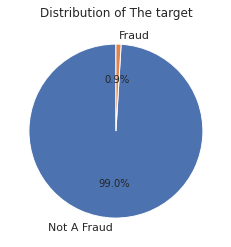

In [ ]:
# Create the pie chart
plt.pie(all_data['fraud'].value_counts(), labels=['Not A Fraud', 'Fraud'], autopct='%1.1f%%', startangle=90)

# Add a title
plt.title('Distribution of The target')

# Display the chart
plt.show()

In [ ]:
all_data['gender'].value_counts()

M    5448
F    4552
Name: gender, dtype: int64

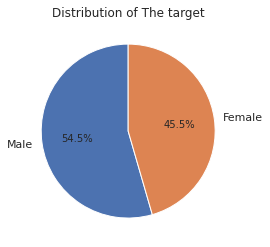

In [ ]:
# Create the pie chart
plt.pie(all_data['gender'].value_counts(), labels=['Male', 'Female'], autopct='%1.1f%%', startangle=90)

# Add a title
plt.title('Distribution of The target')

# Display the chart
plt.show()

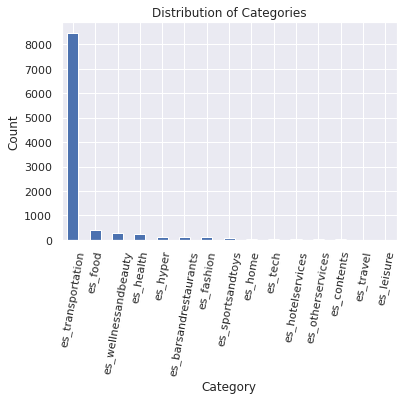

In [ ]:
# Assuming you have a DataFrame called 'df' with a categorical column called 'category'

# Count the occurrences of each category
category_counts = all_data['category'].value_counts()

# Plot the results as a bar plot
category_counts.plot(kind='bar', )

# Set labels and title
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Distribution of Categories')
plt.xticks(rotation=80)

# Show the plot
plt.show()

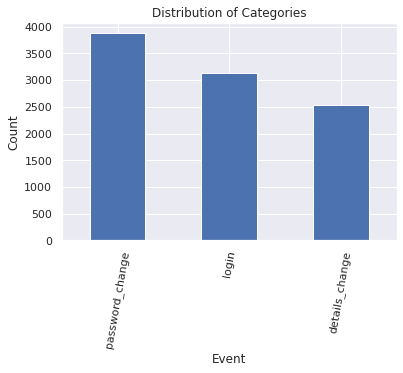

In [ ]:
# Assuming you have a DataFrame called 'df' with a categorical column called 'category'

# Count the occurrences of each category
category_counts = all_data['event'].value_counts()

# Plot the results as a bar plot
category_counts.plot(kind='bar', )

# Set labels and title
plt.xlabel('Event')
plt.ylabel('Count')
plt.title('Distribution of Categories')
plt.xticks(rotation=80)

# Show the plot
plt.show()

In [ ]:
all_data = pd.get_dummies(all_data, columns=['category', 'gender', 'event'])

When we have a dimension of time in the data, a good practice is to look at the distribution of features against our time, of course after breaking down the time into days, hours, months, etc.

Here you can see the distribution of the the fare amount vs time.

In [ ]:
all_data["timestamp"] = pd.to_datetime(
        all_data["timestamp"], format="%Y-%m-%d %H:%M:%S UTC"
    )

all_data["hour"] = all_data.timestamp.dt.hour
all_data["day"] = all_data.timestamp.dt.day
all_data["month"] = all_data.timestamp.dt.month
all_data["weekday"] = all_data.timestamp.dt.weekday
all_data["year"] = all_data.timestamp.dt.year

Text(0.5, 1.0, 'Count of fraud/not fraud for each hour')

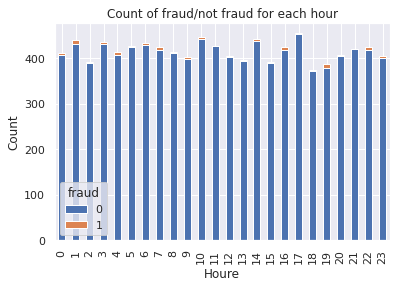

In [ ]:
grouped = all_data.groupby('hour')['fraud'].value_counts().unstack().fillna(0)
# Plot the results
grouped.plot(kind='bar', stacked=True)

# Set labels and title
plt.xlabel('Houre')
plt.ylabel('Count')
plt.title('Count of fraud/not fraud for each hour')

Text(0.5, 1.0, 'Count of fraud/not fraud for each day of the week')

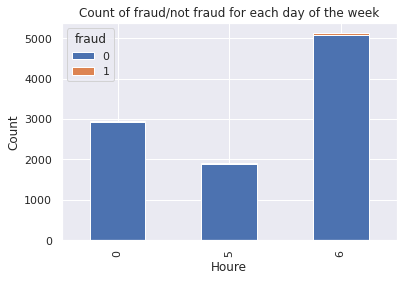

In [ ]:
grouped = all_data.groupby('weekday')['fraud'].value_counts().unstack().fillna(0)
# Plot the results
grouped.plot(kind='bar', stacked=True)

# Set labels and title
plt.xlabel('Houre')
plt.ylabel('Count')
plt.title('Count of fraud/not fraud for each day of the week')

In addition, it is worth looking at the correlation matrix between the various features, with the help of which maybe to dilute some of them in order to or maybe even connect them to a single feature

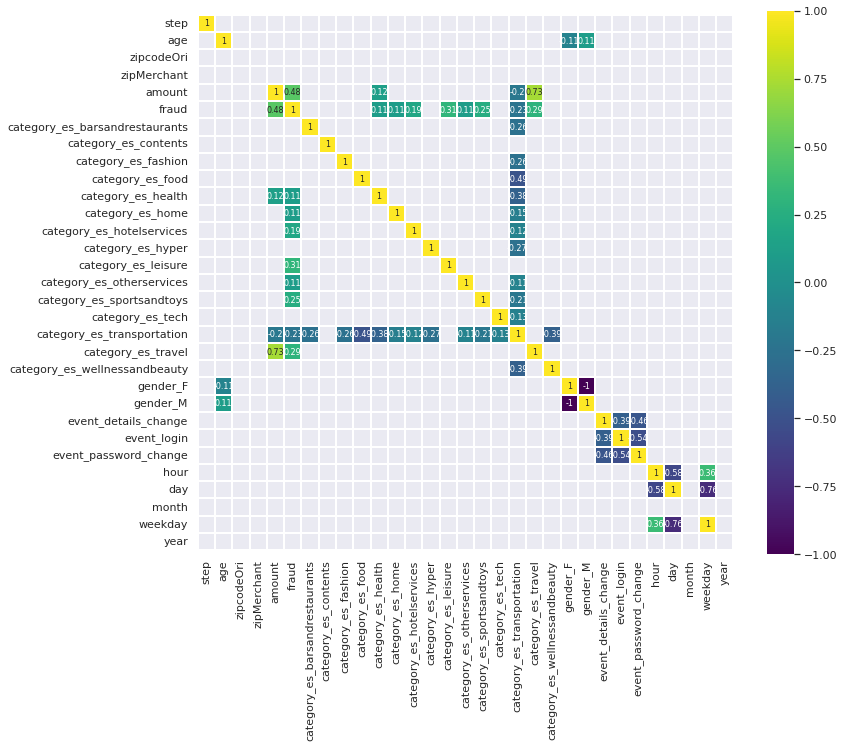

In [ ]:
corr = all_data.corr()
plt.figure(figsize=(12, 10))

sns.heatmap(corr[(corr >= 0.1) | (corr <= -0.1)], 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True);

Conclusions that arose from the following analysis:

    1. It can be seen that all of our geographic parameters have outliers when longitude<-200 and latitude>200

    2. Fare amount includes also outliers.

    3. The number of passengers is a number between 1 to 6 can be considered as dummies.

    4. There is a fairly equal distribution of the fare amount against time.

Of course, this is a notebook that presents only a basic and initial analysis of the data, you can see more detailed examples of the analysis in the following links : 
1. https://medium.com/analytics-vidhya/exploratory-data-analysis-of-nyc-taxi-trip-duration-dataset-using-python-257fdef2749e
2. https://www.analyticsvidhya.com/blog/2021/01/exploratory-data-analysis-on-nyc-taxi-trip-duration-dataset/

### Analyis with MLRUN

You can see by simply running the describe function from our Market Place you can get a lot of information about the data and perform a qualitative and in-depth analysis on it.

In [23]:
all_data.to_csv('./data_set_describe.csv', index=False)


import mlrun

project = mlrun.get_or_create_project(
    name="ny-taxi-eda", user_project=True, context="./"
)

# import the function
describe = mlrun.import_function('hub://describe')

describe_run = describe.run(params={'label_column': 'fraud',},
                            inputs={"table": './data_set_describe.csv'}, local=True)

> 2023-06-19 14:37:21,719 [info] Loaded project ny-taxi-eda from MLRun DB
> 2023-06-19 14:37:21,947 [info] Storing function: {'name': 'describe-analyze', 'uid': '5885e203cc95448aaa43878cc0a3907b', 'db': 'http://mlrun-api:8080'}
> 2023-06-19 14:37:22,139 [info] Trying to use the default packager to unpack the data item 'table'
> 2023-06-19 14:37:22,166 [error] execution error, Traceback (most recent call last):
  File "/User/.pythonlibs/mlrun-base/lib/python3.9/site-packages/mlrun/package/packagers_manager.py", line 288, in unpack
    return self._unpack_data_item(
  File "/User/.pythonlibs/mlrun-base/lib/python3.9/site-packages/mlrun/package/packagers_manager.py", line 689, in _unpack_data_item
    raise MLRunPackageUnpackingError(
mlrun.package.errors.MLRunPackageUnpackingError: Could not unpack data item with the hinted type 'typing.Union[mlrun.feature_store.feature_set.FeatureSet, mlrun.datastore.base.DataItem]'. The following packagers were tried to be used to unpack it but raised 

An exception was raised during the unpacking of 'table': Could not unpack data item with the hinted type 'typing.Union[mlrun.feature_store.feature_set.FeatureSet, mlrun.datastore.base.DataItem]'. The following packagers were tried to be used to unpack it but raised the exceptions joined:

Found packager: 'DefaultPackager(packable_type=Any, artifact_types=['object', 'result'], priority=Ellipsis)'
Exception: Traceback (most recent call last):
  File "/User/.pythonlibs/mlrun-base/lib/python3.9/site-packages/mlrun/package/packagers_manager.py", line 673, in _unpack_data_item
    return self._default_packager.unpack(
  File "/User/.pythonlibs/mlrun-base/lib/python3.9/site-packages/mlrun/package/packagers/default_packager.py", line 237, in unpack
    return unpack_method(data_item, **instructions)
  File "/User/.pythonlibs/mlrun-base/lib/python3.9/site-packages/mlrun/package/packagers/default_packager.py", line 352, in unpack_object
    return Pickler.unpickle(
  File "/User/.pythonlibs/mlru

project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
ny-taxi-eda-admin,...c0a3907b,0,Jun 19 14:37:22,"<div style=""color: red;"" title=""An exception was raised during the unpacking of 'table': Could not unpack data item with the hinted type 'typing.Union[mlrun.feature_store.feature_set.FeatureSet, mlrun.datastore.base.DataItem]'. The following packagers were tried to be used to unpack it but raised the exceptions joined:\n\nFound packager: 'DefaultPackager(packable_type=Any, artifact_types=['object', 'result'], priority=Ellipsis)'\nException: Traceback (most recent call last):\n File ""/User/.pythonlibs/mlrun-base/lib/python3.9/site-packages/mlrun/package/packagers_manager.py"", line 673, in _unpack_data_item\n return self._default_packager.unpack(\n File ""/User/.pythonlibs/mlrun-base/lib/python3.9/site-packages/mlrun/package/packagers/default_packager.py"", line 237, in unpack\n return unpack_method(data_item, **instructions)\n File ""/User/.pythonlibs/mlrun-base/lib/python3.9/site-packages/mlrun/package/packagers/default_packager.py"", line 352, in unpack_object\n return Pickler.unpickle(\n File ""/User/.pythonlibs/mlrun-base/lib/python3.9/site-packages/mlrun/package/utils/_pickler.py"", line 159, in unpickle\n obj = pickle_module.load(pickle_file)\n_pickle.UnpicklingError: unpickling stack underflow\n\n, caused by: Could not unpack data item with the hinted type 'typing.Union[mlrun.feature_store.feature_set.FeatureSet, mlrun.datastore.base.DataItem]'. The following packagers were tried to be used to unpack it but raised the exceptions joined:\n\nFound packager: 'DefaultPackager(packable_type=Any, artifact_types=['object', 'result'], priority=Ellipsis)'\nException: Traceback (most recent call last):\n File ""/User/.pythonlibs/mlrun-base/lib/python3.9/site-packages/mlrun/package/packagers_manager.py"", line 673, in _unpack_data_item\n return self._default_packager.unpack(\n File ""/User/.pythonlibs/mlrun-base/lib/python3.9/site-packages/mlrun/package/packagers/default_packager.py"", line 237, in unpack\n return unpack_method(data_item, **instructions)\n File ""/User/.pythonlibs/mlrun-base/lib/python3.9/site-packages/mlrun/package/packagers/default_packager.py"", line 352, in unpack_object\n return Pickler.unpickle(\n File ""/User/.pythonlibs/mlrun-base/lib/python3.9/site-packages/mlrun/package/utils/_pickler.py"", line 159, in unpickle\n obj = pickle_module.load(pickle_file)\n_pickle.UnpicklingError: unpickling stack underflow\n\n"">error",describe-analyze,v3io_user=adminkind=owner=adminhost=jupyter-74c86b8866-d2vpm,table,label_column=fraud,,


> 2023-06-19 14:37:22,314 [info] Run executed, status=error: {'name': 'describe-analyze'}


RunError: An exception was raised during the unpacking of 'table': Could not unpack data item with the hinted type 'typing.Union[mlrun.feature_store.feature_set.FeatureSet, mlrun.datastore.base.DataItem]'. The following packagers were tried to be used to unpack it but raised the exceptions joined:

Found packager: 'DefaultPackager(packable_type=Any, artifact_types=['object', 'result'], priority=Ellipsis)'
Exception: Traceback (most recent call last):
  File "/User/.pythonlibs/mlrun-base/lib/python3.9/site-packages/mlrun/package/packagers_manager.py", line 673, in _unpack_data_item
    return self._default_packager.unpack(
  File "/User/.pythonlibs/mlrun-base/lib/python3.9/site-packages/mlrun/package/packagers/default_packager.py", line 237, in unpack
    return unpack_method(data_item, **instructions)
  File "/User/.pythonlibs/mlrun-base/lib/python3.9/site-packages/mlrun/package/packagers/default_packager.py", line 352, in unpack_object
    return Pickler.unpickle(
  File "/User/.pythonlibs/mlrun-base/lib/python3.9/site-packages/mlrun/package/utils/_pickler.py", line 159, in unpickle
    obj = pickle_module.load(pickle_file)
_pickle.UnpicklingError: unpickling stack underflow

, caused by: Could not unpack data item with the hinted type 'typing.Union[mlrun.feature_store.feature_set.FeatureSet, mlrun.datastore.base.DataItem]'. The following packagers were tried to be used to unpack it but raised the exceptions joined:

Found packager: 'DefaultPackager(packable_type=Any, artifact_types=['object', 'result'], priority=Ellipsis)'
Exception: Traceback (most recent call last):
  File "/User/.pythonlibs/mlrun-base/lib/python3.9/site-packages/mlrun/package/packagers_manager.py", line 673, in _unpack_data_item
    return self._default_packager.unpack(
  File "/User/.pythonlibs/mlrun-base/lib/python3.9/site-packages/mlrun/package/packagers/default_packager.py", line 237, in unpack
    return unpack_method(data_item, **instructions)
  File "/User/.pythonlibs/mlrun-base/lib/python3.9/site-packages/mlrun/package/packagers/default_packager.py", line 352, in unpack_object
    return Pickler.unpickle(
  File "/User/.pythonlibs/mlrun-base/lib/python3.9/site-packages/mlrun/package/utils/_pickler.py", line 159, in unpickle
    obj = pickle_module.load(pickle_file)
_pickle.UnpicklingError: unpickling stack underflow



#### Few examples for plots we get from mlrun describe function.

In [ ]:
# view generated artifacts (charts)
describe_run.outputs

{}

<img src="./images/describe.png" alt="describe" width="1000"/>